In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from shapely.geometry import Point, Polygon

import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import plotly.express as px

from multiprocessing import Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# parameter opimization
from sklearn.model_selection import GridSearchCV

# Validation
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from utils import taxi_zone_df, batch_coordinate_to_census_tract, batch_coordinate_to_zone

sns.set_theme(style="ticks", color_codes=True)

[DEBUG] utils.py: Finished loading supplementary data to memory.


CPU times: user 33.8 ms, sys: 8.36 ms, total: 42.2 ms
Wall time: 40.9 ms


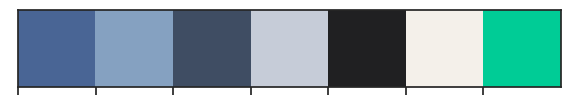

In [2]:
%%time
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plt.rcParams["axes.facecolor"] = primary_bgcolor

colors = [
    primary_blue,
    primary_blue2,
    primary_blue3,
    primary_grey,
    primary_black,
    primary_bgcolor,
    primary_green,
]
sns.palplot(sns.color_palette(colors))

# Experiments

In [3]:
%%time
taxi_zone_df.head()

CPU times: user 157 µs, sys: 130 µs, total: 287 µs
Wall time: 270 µs


,objectid,shape_leng,the_geom,shape_area,zone,location_id,borough
0,1,0.116357,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000782,Newark Airport,1,EWR
1,2,0.433470,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.004866,Jamaica Bay,2,Queens
2,3,0.084341,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000112,Alphabet City,4,Manhattan
4,5,0.092146,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000498,Arden Heights,5,Staten Island


In [4]:
%%time
taxi_2021_df = pd.read_csv("../data/sample/sample_manhattan_taxi_2021_nov.csv", engine="pyarrow")
taxi_2021_df_copy = taxi_2021_df.copy()
taxi_2021_df.head()

CPU times: user 42.4 ms, sys: 10.5 ms, total: 52.9 ms
Wall time: 39.7 ms


,vendor,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,pickup_zone,dropoff_zone,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,VeriFone Inc.,11/28/2021 01:02:49 PM,11/28/2021 01:24:31 PM,1.0,5.03,Standard rate,N,238,107,Credit card,19.0,0.0,0.5,2.00,0.0,0.3,24.30,2.5
1,VeriFone Inc.,11/02/2021 12:32:54 PM,11/02/2021 12:43:27 PM,1.0,1.78,Standard rate,N,163,186,Credit card,8.5,0.0,0.5,10.00,0.0,0.3,21.80,2.5
2,VeriFone Inc.,11/29/2021 04:02:43 PM,11/29/2021 04:15:45 PM,1.0,1.41,Standard rate,N,234,137,Credit card,9.5,1.0,0.5,3.45,0.0,0.3,17.25,2.5
3,VeriFone Inc.,11/25/2021 09:00:13 PM,11/25/2021 09:03:56 PM,1.0,1.51,Standard rate,N,140,75,Cash,6.0,0.5,0.5,0.00,0.0,0.3,9.80,2.5
4,"Creative Mobile Technologies, LLC",11/29/2021 05:44:50 PM,11/29/2021 05:56:43 PM,1.0,1.70,Standard rate,N,230,68,Credit card,9.5,3.5,0.5,2.75,0.0,0.3,16.55,2.5


In [5]:
%%time
taxi_2014_df = pd.read_csv("../data/sample/sample_manhattan_taxi_2014_nov.csv", engine="pyarrow")
taxi_2014_df.head()

CPU times: user 50.4 ms, sys: 4.84 ms, total: 55.2 ms
Wall time: 42.5 ms


,vendor,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_census_tract_idx,dropoff_census_tract_idx,pickup_zone,dropoff_zone
0,"Creative Mobile Technologies, LLC",2014-11-14 16:31:05,2014-11-14 16:39:13,1,1.2,-73.982651,40.742480,Standard rate,N,-73.996067,...,7.0,1.0,0.5,0.0,0.0,8.5,49,43,107,113
1,"Creative Mobile Technologies, LLC",2014-11-21 14:05:09,2014-11-21 14:06:34,1,0.1,-73.965532,40.762567,Standard rate,N,-73.963128,...,3.0,0.0,0.5,0.0,0.0,3.5,95,95,141,141
2,"Creative Mobile Technologies, LLC",2014-11-19 06:59:43,2014-11-19 07:17:14,1,3.8,-74.008932,40.719630,Standard rate,N,-73.973683,...,14.5,0.0,0.5,0.0,0.0,15.0,28,70,231,233
3,"Creative Mobile Technologies, LLC",2014-11-04 16:05:48,2014-11-04 16:10:46,1,0.4,-73.966881,40.751287,Standard rate,N,-73.970490,...,5.0,0.0,0.5,1.1,0.0,6.6,2300,72,233,233
4,"Creative Mobile Technologies, LLC",2014-11-07 09:08:56,2014-11-07 09:19:23,1,1.0,-73.972801,40.762425,Standard rate,N,-73.982154,...,8.0,0.0,0.5,0.0,0.0,8.5,98,135,163,142


In [6]:
taxi_2014_df["pickup_zone"] = batch_coordinate_to_zone(taxi_2014_df)
taxi_2014_df["dropoff_zone"] = batch_coordinate_to_zone(taxi_2014_df, longitude_header="dropoff_longitude", latitude_header="dropoff_latitude")
taxi_2014_df

,vendor,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_census_tract_idx,dropoff_census_tract_idx,pickup_zone,dropoff_zone
0,"Creative Mobile Technologies, LLC",2014-11-14 16:31:05,2014-11-14 16:39:13,1,1.2,-73.982651,40.742480,Standard rate,N,-73.996067,...,7.0,1.0,0.5,0.00,0.0,8.50,49,43,107,113
1,"Creative Mobile Technologies, LLC",2014-11-21 14:05:09,2014-11-21 14:06:34,1,0.1,-73.965532,40.762567,Standard rate,N,-73.963128,...,3.0,0.0,0.5,0.00,0.0,3.50,95,95,141,141
2,"Creative Mobile Technologies, LLC",2014-11-19 06:59:43,2014-11-19 07:17:14,1,3.8,-74.008932,40.719630,Standard rate,N,-73.973683,...,14.5,0.0,0.5,0.00,0.0,15.00,28,70,231,233
3,"Creative Mobile Technologies, LLC",2014-11-04 16:05:48,2014-11-04 16:10:46,1,0.4,-73.966881,40.751287,Standard rate,N,-73.970490,...,5.0,0.0,0.5,1.10,0.0,6.60,2300,72,233,233
4,"Creative Mobile Technologies, LLC",2014-11-07 09:08:56,2014-11-07 09:19:23,1,1.0,-73.972801,40.762425,Standard rate,N,-73.982154,...,8.0,0.0,0.5,0.00,0.0,8.50,98,135,163,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"Creative Mobile Technologies, LLC",2014-11-14 12:37:33,2014-11-14 12:44:48,2,0.8,-73.981729,40.762322,Standard rate,N,-73.989095,...,6.5,0.0,0.5,1.40,0.0,8.40,116,94,230,100
996,"Creative Mobile Technologies, LLC",2014-11-28 23:48:34,2014-11-29 00:00:10,1,2.3,-73.981588,40.730962,Standard rate,N,-74.002654,...,10.5,0.5,0.5,0.00,0.0,11.50,24,82,224,246
997,"Creative Mobile Technologies, LLC",2014-11-23 23:28:16,2014-11-23 23:37:58,1,2.3,-74.004273,40.741764,Standard rate,N,-73.985286,...,9.5,0.5,0.5,0.00,0.0,10.50,65,110,68,230
998,"Creative Mobile Technologies, LLC",2014-11-22 22:31:07,2014-11-22 22:44:54,1,0.8,-73.997312,40.725601,Standard rate,N,-73.982045,...,10.0,0.5,0.5,2.75,0.0,13.75,35,9,211,232


In [7]:
taxi_2021_df["pickup_datetime"] = pd.to_datetime(taxi_2021_df["pickup_datetime"])
taxi_2021_df["dropoff_datetime"] = pd.to_datetime(taxi_2021_df["dropoff_datetime"])

taxi_2014_df["pickup_datetime"] = pd.to_datetime(taxi_2014_df["pickup_datetime"])
taxi_2014_df["dropoff_datetime"] = pd.to_datetime(taxi_2014_df["dropoff_datetime"])

taxi_2021_df["pickup_hour"] = taxi_2021_df["pickup_datetime"].dt.hour
taxi_2021_df["pickup_min"] = taxi_2021_df["pickup_datetime"].dt.minute
taxi_2021_df["pickup_weekday"] = taxi_2021_df["pickup_datetime"].dt.weekday

taxi_2014_df["pickup_hour"] = taxi_2014_df["pickup_datetime"].dt.hour
taxi_2014_df["pickup_min"] = taxi_2014_df["pickup_datetime"].dt.minute
taxi_2014_df["pickup_weekday"] = taxi_2014_df["pickup_datetime"].dt.weekday

taxi_2021_df["dropoff_hour"] = taxi_2021_df["dropoff_datetime"].dt.hour
taxi_2021_df["dropoff_min"] = taxi_2021_df["dropoff_datetime"].dt.minute
taxi_2021_df["dropoff_weekday"] = taxi_2021_df["dropoff_datetime"].dt.weekday

taxi_2014_df["dropoff_hour"] = taxi_2014_df["dropoff_datetime"].dt.hour
taxi_2014_df["dropoff_min"] = taxi_2014_df["dropoff_datetime"].dt.minute
taxi_2014_df["dropoff_weekday"] = taxi_2014_df["dropoff_datetime"].dt.weekday

In [8]:
%%time
# Visualization, sampling 5000 datas.
mapping_1st = pd.DataFrame(
    {
        "date": taxi_2014_df["pickup_datetime"].values,
        "lat": taxi_2014_df["pickup_latitude"].values,
        "lon": taxi_2014_df["pickup_longitude"].values,
    }
)

mapping_last = pd.DataFrame(
    {
        "date": taxi_2014_df["dropoff_datetime"].values,
        "lat": taxi_2014_df["dropoff_latitude"].values,
        "lon": taxi_2014_df["dropoff_longitude"].values,
    }
)

por_map = folium.Map(
    location=[40.7128, -74.0060], tiles="Stamen Terrain", zoom_start=11
)

for i, r in mapping_1st.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="red").add_to(
        por_map
    )

for i, r in mapping_last.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="blue").add_to(
        por_map
    )

por_map

CPU times: user 145 ms, sys: 12.8 ms, total: 157 ms
Wall time: 151 ms


In [9]:
%%time
ml_2014_df = taxi_2014_df.copy()
ml_2014_df = ml_2014_df.fillna(0)
ml_2014_df.head()

CPU times: user 5.56 ms, sys: 869 µs, total: 6.43 ms
Wall time: 5.55 ms


,vendor,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,pickup_census_tract_idx,dropoff_census_tract_idx,pickup_zone,dropoff_zone,pickup_hour,pickup_min,pickup_weekday,dropoff_hour,dropoff_min,dropoff_weekday
0,"Creative Mobile Technologies, LLC",2014-11-14 16:31:05,2014-11-14 16:39:13,1,1.2,-73.982651,40.742480,Standard rate,N,-73.996067,...,49,43,107,113,16,31,4,16,39,4
1,"Creative Mobile Technologies, LLC",2014-11-21 14:05:09,2014-11-21 14:06:34,1,0.1,-73.965532,40.762567,Standard rate,N,-73.963128,...,95,95,141,141,14,5,4,14,6,4
2,"Creative Mobile Technologies, LLC",2014-11-19 06:59:43,2014-11-19 07:17:14,1,3.8,-74.008932,40.719630,Standard rate,N,-73.973683,...,28,70,231,233,6,59,2,7,17,2
3,"Creative Mobile Technologies, LLC",2014-11-04 16:05:48,2014-11-04 16:10:46,1,0.4,-73.966881,40.751287,Standard rate,N,-73.970490,...,2300,72,233,233,16,5,1,16,10,1
4,"Creative Mobile Technologies, LLC",2014-11-07 09:08:56,2014-11-07 09:19:23,1,1.0,-73.972801,40.762425,Standard rate,N,-73.982154,...,98,135,163,142,9,8,4,9,19,4


In [10]:
%%time
ml_2021_df = taxi_2021_df.copy()
ml_2021_df = ml_2021_df.fillna(0)
ml_2021_df.head()

CPU times: user 1.77 ms, sys: 4.52 ms, total: 6.29 ms
Wall time: 5.03 ms


,vendor,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,pickup_zone,dropoff_zone,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,pickup_min,pickup_weekday,dropoff_hour,dropoff_min,dropoff_weekday
0,VeriFone Inc.,2021-11-28 13:02:49,2021-11-28 13:24:31,1.0,5.03,Standard rate,N,238,107,Credit card,...,0.0,0.3,24.30,2.5,13,2,6,13,24,6
1,VeriFone Inc.,2021-11-02 12:32:54,2021-11-02 12:43:27,1.0,1.78,Standard rate,N,163,186,Credit card,...,0.0,0.3,21.80,2.5,12,32,1,12,43,1
2,VeriFone Inc.,2021-11-29 16:02:43,2021-11-29 16:15:45,1.0,1.41,Standard rate,N,234,137,Credit card,...,0.0,0.3,17.25,2.5,16,2,0,16,15,0
3,VeriFone Inc.,2021-11-25 21:00:13,2021-11-25 21:03:56,1.0,1.51,Standard rate,N,140,75,Cash,...,0.0,0.3,9.80,2.5,21,0,3,21,3,3
4,"Creative Mobile Technologies, LLC",2021-11-29 17:44:50,2021-11-29 17:56:43,1.0,1.70,Standard rate,N,230,68,Credit card,...,0.0,0.3,16.55,2.5,17,44,0,17,56,0


In [11]:
categorical_columns = [
    "pickup_zone",
    "dropoff_zone",
    "store_and_fwd_flag",
    "payment_type",
    "vendor",
]

encodings = []
new_encodings = []
for col_name in categorical_columns:
    col = ml_2014_df[col_name]
    new_col = ml_2021_df[col_name]
    encodings.append(pd.get_dummies(col, prefix=col_name))
    new_encodings.append(pd.get_dummies(new_col, prefix=col_name))

In [12]:
X = ml_2014_df[
    [
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "total_amount",
        "pickup_weekday",
        "pickup_hour",
        "pickup_min",
    ]
]

X = pd.concat([X] + encodings, axis=1)
X.head()

,passenger_count,trip_distance,fare_amount,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_min,...,dropoff_zone_261,dropoff_zone_262,dropoff_zone_263,store_and_fwd_flag_N,store_and_fwd_flag_Y,payment_type_Cash,payment_type_Credit card,payment_type_Dispute,payment_type_No charge,"vendor_Creative Mobile Technologies, LLC"
0,1,1.2,7.0,0.5,0.0,0.0,8.5,4,16,31,...,0,0,0,1,0,1,0,0,0,1
1,1,0.1,3.0,0.5,0.0,0.0,3.5,4,14,5,...,0,0,0,1,0,1,0,0,0,1
2,1,3.8,14.5,0.5,0.0,0.0,15.0,2,6,59,...,0,0,0,1,0,1,0,0,0,1
3,1,0.4,5.0,0.5,1.1,0.0,6.6,1,16,5,...,0,0,0,1,0,0,1,0,0,1
4,1,1.0,8.0,0.5,0.0,0.0,8.5,4,9,8,...,0,0,0,1,0,1,0,0,0,1


In [13]:
y = ml_2014_df[["dropoff_longitude", "dropoff_latitude"]]
y.head()

,dropoff_longitude,dropoff_latitude
0,-73.996067,40.732543
1,-73.963128,40.762559
2,-73.973683,40.750544
3,-73.970490,40.754684
4,-73.982154,40.771380


In [14]:
X_test = ml_2021_df[
    [
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "total_amount",
        "pickup_weekday",
        "pickup_hour",
        "pickup_min",
    ]
]

X_test = pd.concat([X_test] + new_encodings, axis=1)
X_test = X_test.reindex(columns=X.columns, fill_value=0)
X_test.head()

,passenger_count,trip_distance,fare_amount,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_min,...,dropoff_zone_261,dropoff_zone_262,dropoff_zone_263,store_and_fwd_flag_N,store_and_fwd_flag_Y,payment_type_Cash,payment_type_Credit card,payment_type_Dispute,payment_type_No charge,"vendor_Creative Mobile Technologies, LLC"
0,1.0,5.03,19.0,0.5,2.00,0.0,24.30,6,13,2,...,0,0,0,1,0,0,1,0,0,0
1,1.0,1.78,8.5,0.5,10.00,0.0,21.80,1,12,32,...,0,0,0,1,0,0,1,0,0,0
2,1.0,1.41,9.5,0.5,3.45,0.0,17.25,0,16,2,...,0,0,0,1,0,0,1,0,0,0
3,1.0,1.51,6.0,0.5,0.00,0.0,9.80,3,21,0,...,0,0,0,1,0,1,0,0,0,0
4,1.0,1.70,9.5,0.5,2.75,0.0,16.55,0,17,44,...,0,0,0,1,0,0,1,0,0,1


In [15]:
y_test = ml_2021_df[["dropoff_zone"]].fillna(0).astype(int)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
results = dict()

In [18]:
%%time
forest = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=4)
)

# Fitting
forest = forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_valid_pred = forest.predict(X_valid)
y_test_pred = forest.predict(X_test)

y_test_pred_df = pd.DataFrame(
    y_test_pred, columns=["dropoff_longitude", "dropoff_latitude"]
    # y_test_pred, columns=["pickup_longitude", "pickup_latitude"]
)
y_test_pred_zones = batch_coordinate_to_zone(
    y_test_pred_df,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
    # y_test_pred_df,
    # longitude_header="pickup_longitude",
    # latitude_header="pickup_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred)
    )
)
print(
    "Mean Square Error on validation Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_zones)))

results["random_forest"] = [
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_valid, y_valid_pred),
    r2_score(y_train, y_train_pred),
    r2_score(y_valid, y_valid_pred),
    accuracy_score(y_test, y_test_pred_zones)
]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs

Mean Square Error on training Data: 6.362723535202303e-06
Mean Square Error on validation Data: 1.2235129091000976e-05
R2 score train: 0.9858961024800529
R2 score valid: 0.9656920009058167
Zone accuracy test: 0.949
CPU times: user 973 ms, sys: 115 ms, total: 1.09 s
Wall time: 1.83 s


In [19]:
%%time
boosting = MultiOutputRegressor(GradientBoostingRegressor(verbose=1))

# Fitting
boosting = boosting.fit(X_train, y_train)
y_train_pred_2 = boosting.predict(X_train)
y_valid_pred_2 = boosting.predict(X_valid)
y_test_pred_2 = boosting.predict(X_test)

y_test_pred_2_df = pd.DataFrame(
    y_test_pred_2, columns=["dropoff_longitude", "dropoff_latitude"]
)
y_test_pred_2_zones = batch_coordinate_to_zone(
    y_test_pred_2_df,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred_2)
    )
)
print(
    "Mean Square Error on testing Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred_2)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred_2)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred_2)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_2_zones)))

results["gradient_boost"] = [
    mean_squared_error(y_train, y_train_pred_2),
    mean_squared_error(y_valid, y_valid_pred_2),
    r2_score(y_train, y_train_pred_2),
    r2_score(y_valid, y_valid_pred_2),
    accuracy_score(y_test, y_test_pred_2_zones)
]

      Iter       Train Loss   Remaining Time 
         1           0.0003            0.36s
         2           0.0003            0.35s
         3           0.0003            0.34s
         4           0.0003            0.31s
         5           0.0003            0.29s
         6           0.0002            0.27s
         7           0.0002            0.26s
         8           0.0002            0.24s
         9           0.0002            0.23s
        10           0.0002            0.22s
        20           0.0002            0.17s
        30           0.0001            0.14s
        40           0.0001            0.11s
        50           0.0001            0.09s
        60           0.0001            0.07s
        70           0.0001            0.05s
        80           0.0001            0.04s
        90           0.0001            0.02s
       100           0.0001            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0005            0.17s
        

In [20]:
%%time
lr = MultiOutputRegressor(LinearRegression(n_jobs=4))

# Fitting
lr = lr.fit(X_train, y_train)
y_train_pred_3 = lr.predict(X_train)
y_valid_pred_3 = lr.predict(X_valid)
y_test_pred_3 = lr.predict(X_test)

y_test_pred_3_df = pd.DataFrame(
    y_test_pred_3, columns=["dropoff_longitude", "dropoff_latitude"]
)
y_test_pred_3_zones = batch_coordinate_to_zone(
    y_test_pred_3_df,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred_3)
    )
)
print(
    "Mean Square Error on validation Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred_3)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred_3)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred_3)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_3_zones)))

results["linear_regression"] = [
    mean_squared_error(y_train, y_train_pred_3),
    mean_squared_error(y_valid, y_valid_pred_3),
    r2_score(y_train, y_train_pred_3),
    r2_score(y_valid, y_valid_pred_3),
    accuracy_score(y_test, y_test_pred_3_zones)
]

Mean Square Error on training Data: 7.126449905880738e-06
Mean Square Error on validation Data: 1.054630189887312e-05
R2 score train: 0.9820928950000744
R2 score valid: 0.9702137745426337
Zone accuracy test: 0.93
CPU times: user 669 ms, sys: 2.78 s, total: 3.45 s
Wall time: 429 ms


In [21]:
%%time
knn = MultiOutputRegressor(KNeighborsRegressor(n_jobs=4))

# Fitting
knn = knn.fit(X_train, y_train)
y_train_pred_4 = knn.predict(X_train)
y_valid_pred_4 = knn.predict(X_valid)
y_test_pred_4 = knn.predict(X_test)

y_test_pred_4_df = pd.DataFrame(
    y_test_pred_4, columns=["dropoff_longitude", "dropoff_latitude"]
)
y_test_pred_4_zones = batch_coordinate_to_zone(
    y_test_pred_4_df,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred_4)
    )
)
print(
    "Mean Square Error on validation Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred_4)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred_4)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred_4)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_4_zones)))

results["knn_regression"] = [
    mean_squared_error(y_train, y_train_pred_4),
    mean_squared_error(y_valid, y_valid_pred_4),
    r2_score(y_train, y_train_pred_4),
    r2_score(y_valid, y_valid_pred_4),
    accuracy_score(y_test, y_test_pred_4_zones)
]

Mean Square Error on training Data: 0.00033180218499247215
Mean Square Error on validation Data: 0.00046500337005048816
R2 score train: 0.21669392126634818
R2 score valid: -0.27360433265877426
Zone accuracy test: 0.035
CPU times: user 9.25 s, sys: 57.3 ms, total: 9.31 s
Wall time: 932 ms


In [22]:
%%time
dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=50))

# Fitting
dt = dt.fit(X_train, y_train)
y_train_pred_5 = dt.predict(X_train)
y_valid_pred_5 = dt.predict(X_valid)
y_test_pred_5 = dt.predict(X_test)

y_test_pred_5_df = pd.DataFrame(
    y_test_pred_5, columns=["dropoff_longitude", "dropoff_latitude"]
)
y_test_pred_5_zones = batch_coordinate_to_zone(
    y_test_pred_5_df,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred_5)
    )
)
print(
    "Mean Square Error on validation Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred_5)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred_5)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred_5)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_5_zones)))

results["decision_tree"] = [
    mean_squared_error(y_train, y_train_pred_5),
    mean_squared_error(y_valid, y_valid_pred_5),
    r2_score(y_train, y_train_pred_5),
    r2_score(y_valid, y_valid_pred_5),
    accuracy_score(y_test, y_test_pred_5_zones)
]

Mean Square Error on training Data: 3.3347061330060645e-06
Mean Square Error on validation Data: 1.794107726725081e-05
R2 score train: 0.9923362333937642
R2 score valid: 0.9506402808705446
Zone accuracy test: 0.737
CPU times: user 394 ms, sys: 3.35 ms, total: 397 ms
Wall time: 395 ms


In [23]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df.columns = ["train_mse", "valid_mse", "train_r2", "valid_r2", "test_zone_acc"]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={"index": "model"})
results_df.to_csv("results.csv", index=False)

In [24]:
%%time
# Visualization (Random Forest)
coord_gt = pd.DataFrame(
    {"lat": y_valid["dropoff_latitude"], "lon": y_valid["dropoff_longitude"]}
)

coord_pred = pd.DataFrame({"lat": y_valid_pred[:, 1], "lon": y_valid_pred[:, 0]})

por_map = folium.Map(
    location=[40.7528, -73.9800], tiles="Stamen Terrain", zoom_start=12
)

for i, r in coord_gt.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="blue").add_to(
        por_map
    )

for i, r in coord_pred.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="red").add_to(
        por_map
    )

por_map

CPU times: user 36.6 ms, sys: 2.73 ms, total: 39.3 ms
Wall time: 38.2 ms


In [25]:
%%time
# Visualization (Graident Boost)
coord_gt = pd.DataFrame(
    {"lat": y_valid["dropoff_latitude"], "lon": y_valid["dropoff_longitude"]}
)

coord_pred = pd.DataFrame({"lat": y_valid_pred_2[:, 1], "lon": y_valid_pred_2[:, 0]})

por_map = folium.Map(
    location=[40.7528, -73.9800], tiles="Stamen Terrain", zoom_start=12
)

for i, r in coord_gt.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="blue").add_to(
        por_map
    )

for i, r in coord_pred.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="red").add_to(
        por_map
    )

por_map

CPU times: user 37.2 ms, sys: 294 µs, total: 37.5 ms
Wall time: 34.6 ms


In [26]:
%%time
# Visualization (Linear Regression)
coord_gt = pd.DataFrame(
    {"lat": y_valid["dropoff_latitude"], "lon": y_valid["dropoff_longitude"]}
)

coord_pred = pd.DataFrame({"lat": y_valid_pred_3[:, 1], "lon": y_valid_pred_3[:, 0]})

por_map = folium.Map(
    location=[40.7528, -73.9800], tiles="Stamen Terrain", zoom_start=12
)

for i, r in coord_gt.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="blue").add_to(
        por_map
    )

for i, r in coord_pred.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="red").add_to(
        por_map
    )

por_map

CPU times: user 35.6 ms, sys: 4.08 ms, total: 39.7 ms
Wall time: 36.5 ms


In [27]:
%%time
# Visualization (KNN)
coord_gt = pd.DataFrame(
    {"lat": y_valid["dropoff_latitude"], "lon": y_valid["dropoff_longitude"]}
)

coord_pred = pd.DataFrame({"lat": y_valid_pred_4[:, 1], "lon": y_valid_pred_4[:, 0]})

por_map = folium.Map(
    location=[40.7528, -73.9800], tiles="Stamen Terrain", zoom_start=12
)

for i, r in coord_gt.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="blue").add_to(
        por_map
    )

for i, r in coord_pred.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="red").add_to(
        por_map
    )

por_map

CPU times: user 37.5 ms, sys: 394 µs, total: 37.9 ms
Wall time: 36.2 ms


In [28]:
%%time
# Visualization (Decision Tree)
coord_gt = pd.DataFrame(
    {"lat": y_valid["dropoff_latitude"], "lon": y_valid["dropoff_longitude"]}
)

coord_pred = pd.DataFrame({"lat": y_valid_pred_5[:, 1], "lon": y_valid_pred_5[:, 0]})

por_map = folium.Map(
    location=[40.7528, -73.9800], tiles="Stamen Terrain", zoom_start=12
)

for i, r in coord_gt.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="blue").add_to(
        por_map
    )

for i, r in coord_pred.iterrows():
    folium.CircleMarker(location=[r["lat"], r["lon"]], radius=0.5, color="red").add_to(
        por_map
    )

por_map

CPU times: user 34.2 ms, sys: 3.33 ms, total: 37.6 ms
Wall time: 34.9 ms


# Predict the Coordinates

In [ ]:
%%time
ml_2014_df = taxi_2014_df.copy()
ml_2014_df.head()

In [ ]:
%%time
ml_2021_df = taxi_2021_df.copy()
ml_2021_df = ml_2021_df.fillna(0)
ml_2021_df.head()

In [ ]:
categorical_columns = [
    "pickup_zone",
    "dropoff_zone",
    "store_and_fwd_flag",
    "payment_type",
    "vendor",
]

encodings = []
new_encodings = []
for col_name in categorical_columns:
    col = ml_2014_df[col_name]
    new_col = ml_2021_df[col_name]
    encodings.append(pd.get_dummies(col, prefix=col_name))
    new_encodings.append(pd.get_dummies(new_col, prefix=col_name))

## Dropoff Coordinate Prediction

In [ ]:
X = ml_2014_df[
    [
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "total_amount",
        "pickup_weekday",
        "pickup_hour",
        "pickup_min",
    ]
]

X = pd.concat([X] + encodings, axis=1)
X.head()

In [ ]:
y = ml_2014_df[["dropoff_longitude", "dropoff_latitude"]]
y.head()

In [ ]:
X_test = ml_2021_df[
    [
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "total_amount",
        "pickup_weekday",
        "pickup_hour",
        "pickup_min",
    ]
]

X_test = pd.concat([X_test] + new_encodings, axis=1)
X_test = X_test.reindex(columns=X.columns, fill_value=0)
X_test.head()

In [ ]:
y_test = ml_2021_df[["dropoff_zone"]].fillna(0).astype(int)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
%%time
forest_dropoff = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=4)
)

# Fitting
forest_dropoff = forest_dropoff.fit(X_train, y_train)
y_train_pred = forest_dropoff.predict(X_train)
y_valid_pred = forest_dropoff.predict(X_valid)
y_test_pred = forest_dropoff.predict(X_test)

y_test_pred_dropoff_df = pd.DataFrame(
    y_test_pred, columns=["dropoff_longitude", "dropoff_latitude"]
)
y_test_pred_dropoff_zones = batch_coordinate_to_zone(
    y_test_pred_dropoff_df,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred)
    )
)
print(
    "Mean Square Error on validation Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_dropoff_zones)))

In [ ]:
y_test_pred_dropoff_df

##  Pickup Coordinate Prediction

In [ ]:
X = ml_2014_df[
    [
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "total_amount",
        "dropoff_weekday",
        "dropoff_hour",
        "dropoff_min",
    ]
]

X = pd.concat([X] + encodings, axis=1)
X.head()

In [ ]:
y = ml_2014_df[["pickup_longitude", "pickup_latitude"]]
y.head()

In [ ]:
X_test = ml_2021_df[
    [
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "total_amount",
        "dropoff_weekday",
        "dropoff_hour",
        "dropoff_min",
    ]
]

X_test = pd.concat([X_test] + new_encodings, axis=1)
X_test = X_test.reindex(columns=X.columns, fill_value=0)
X_test.head()

In [ ]:
y_test = ml_2021_df[["pickup_zone"]].fillna(0).astype(int)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
%%time
forest_pickup = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=4)
)

# Fitting
forest_pickup = forest_pickup.fit(X_train, y_train)
y_train_pred = forest_pickup.predict(X_train)
y_valid_pred = forest_pickup.predict(X_valid)
y_test_pred = forest_pickup.predict(X_test)

y_test_pred_pickup_df = pd.DataFrame(
    y_test_pred, columns=["pickup_longitude", "pickup_latitude"]
)
y_test_pred_pickup_zones = batch_coordinate_to_zone(
    y_test_pred_pickup_df,
    longitude_header="pickup_longitude",
    latitude_header="pickup_latitude"
)

# Evaluation
print(
    "Mean Square Error on training Data: {}".format(
        mean_squared_error(y_train, y_train_pred)
    )
)
print(
    "Mean Square Error on validation Data: {}".format(
        mean_squared_error(y_valid, y_valid_pred)
    )
)
print("R2 score train: {}".format(r2_score(y_train, y_train_pred)))
print("R2 score valid: {}".format(r2_score(y_valid, y_valid_pred)))
print("Zone accuracy test: {}".format(accuracy_score(y_test, y_test_pred_pickup_zones)))

In [ ]:
y_test_pred_pickup_df

## Save Results

In [ ]:
taxi_2021_df_new = pd.concat([taxi_2021_df_copy, y_test_pred_pickup_df, y_test_pred_dropoff_df], axis=1)
taxi_2021_df_new.head()

In [ ]:
taxi_2021_df_new["pickup_census_tract_idx"] = batch_coordinate_to_census_tract(
    taxi_2021_df_new
)
taxi_2021_df_new["dropoff_census_tract_idx"] = batch_coordinate_to_census_tract(
    taxi_2021_df_new,
    longitude_header="dropoff_longitude",
    latitude_header="dropoff_latitude"
)
taxi_2021_df_new

In [ ]:
taxi_2021_df_new.to_csv("../data/sample/sample_manhattan_taxi_2021_nov_final.csv", index=False)